In [1]:
from QHyper.problems.workflow_scheduling import Workflow
from QHyper.problems.algorithms.utils import wfworkflow_to_qhyper_workflow, merge_subworkflows, draw
import wfcommons.wfchef.utils as utils
from QHyper.problems.algorithms.workflow_decomposition import HeftBasedAlgorithm, SimpleSplit, preprocess_workflow

In [2]:
tasks_file =  "workflows_data/workflows/4_tasks_3_machines_2_paths.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 20

In [4]:
workflow = Workflow(tasks_file, machines_file, deadline)

In [5]:
workflow.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task2,6.0,2.0,4.0
Task3,12.0,4.0,8.0
Task4,24.0,8.0,16.0


In [6]:
workflow.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task2,6.0,8.0,8.0
Task3,12.0,16.0,16.0
Task4,24.0,32.0,32.0


In [7]:
# Requires pygraphviz
# apt install -q libgraphviz-dev
# pip install -q pygraphviz
# pip install -q pydot
# workflow.wf_instance.draw()

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

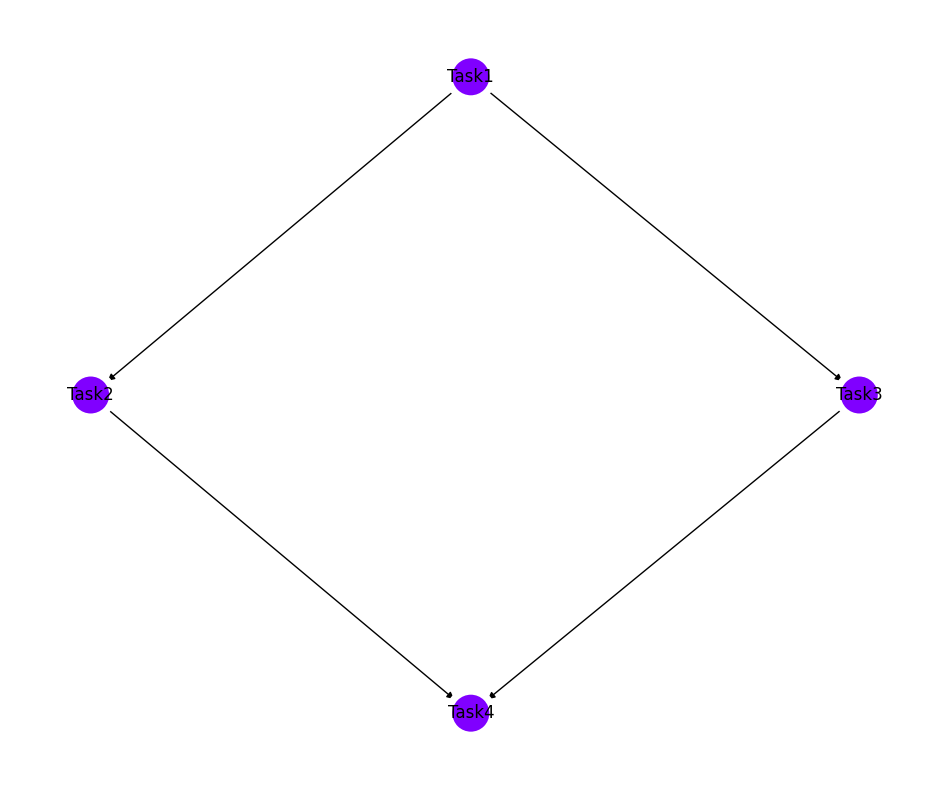

In [8]:
# Prettier way to draw workflow
utils.draw(workflow.wf_instance.workflow, with_labels=True)

In [10]:
decomposition_algorithm = HeftBasedAlgorithm()
workflow1, workflow2 = decomposition_algorithm.decompose(workflow, 2)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

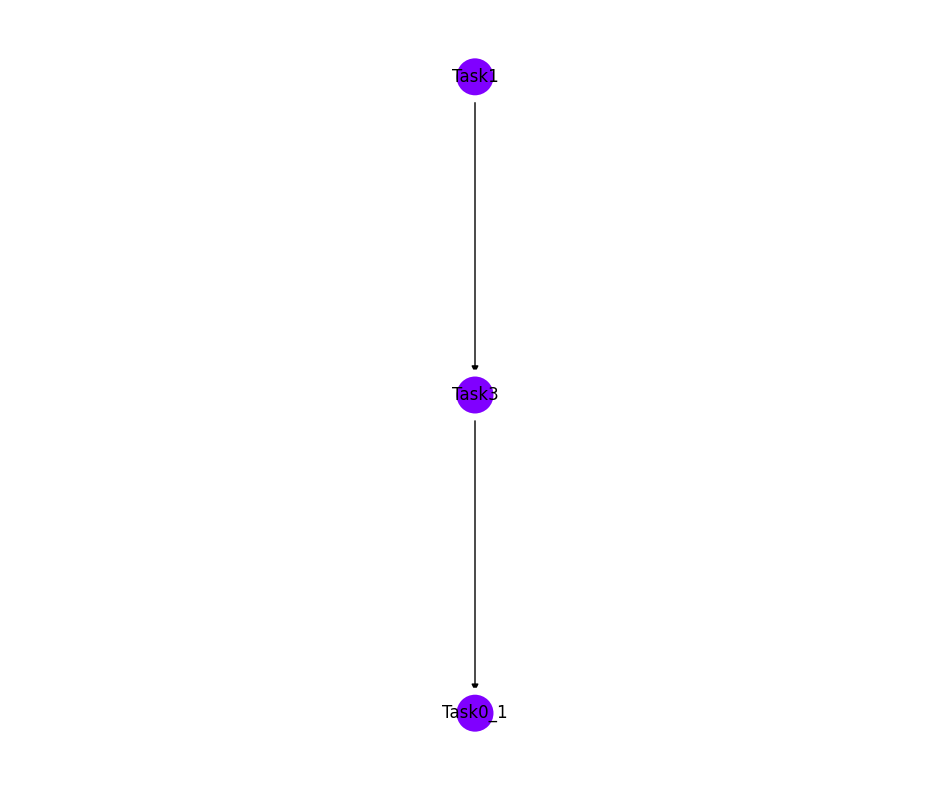

In [11]:
utils.draw(workflow1, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

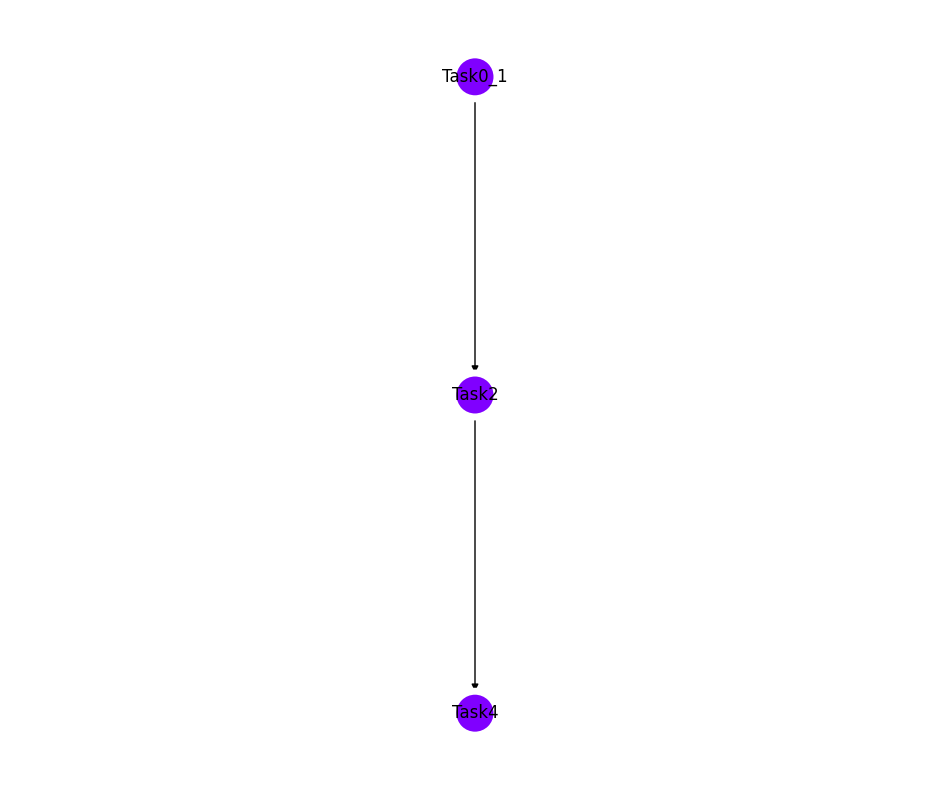

In [12]:
utils.draw(workflow2, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

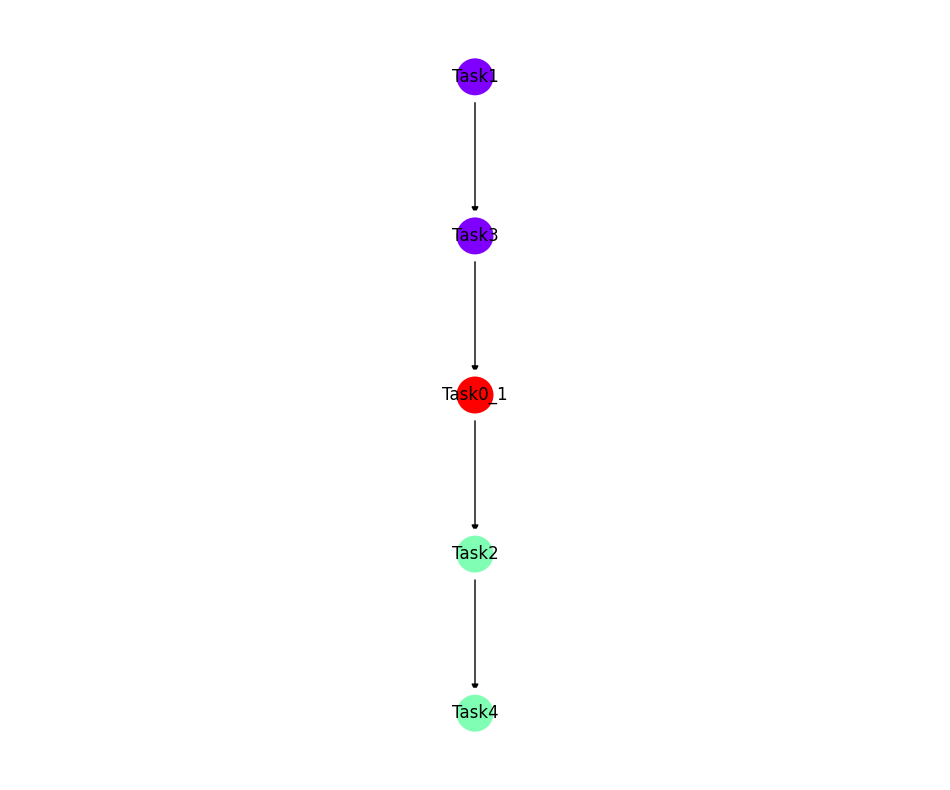

In [14]:
merged = merge_subworkflows([workflow1, workflow2])
utils.draw(merged, with_labels=True)

In [16]:
workflow1 = wfworkflow_to_qhyper_workflow(workflow1, machines_file, deadline/2)
workflow2 = wfworkflow_to_qhyper_workflow(workflow2, machines_file, deadline/2)

In [17]:
workflow1.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task3,12.0,4.0,8.0
Task0_1,0.0,0.0,0.0


In [18]:
workflow1.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task3,12.0,16.0,16.0
Task0_1,0.0,0.0,0.0


In [19]:
workflow2.time_matrix

,MachineA,MachineB,MachineC
Task2,6.0,2.0,4.0
Task4,24.0,8.0,16.0
Task0_1,0.0,0.0,0.0


In [20]:
workflow2.cost_matrix

,MachineA,MachineB,MachineC
Task2,6.0,8.0,8.0
Task4,24.0,32.0,32.0
Task0_1,0.0,0.0,0.0


# Example with more complex workflow

In [2]:
tasks_file =  "workflows_data/workflows/complex_workflow.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50

In [3]:
workflow = Workflow(tasks_file, machines_file, deadline)

In [4]:
workflow.time_matrix

,MachineA,MachineB,MachineC
Task1,3.0,1.0,2.0
Task2,6.0,2.0,4.0
Task3,6.0,2.0,4.0
Task4,6.0,2.0,4.0
Task5,6.0,2.0,4.0
Task6,6.0,2.0,4.0
Task7,9.0,3.0,6.0
Task8,9.0,3.0,6.0
Task9,9.0,3.0,6.0
Task10,12.0,4.0,8.0


In [5]:
workflow.cost_matrix

,MachineA,MachineB,MachineC
Task1,3.0,4.0,4.0
Task2,6.0,8.0,8.0
Task3,6.0,8.0,8.0
Task4,6.0,8.0,8.0
Task5,6.0,8.0,8.0
Task6,6.0,8.0,8.0
Task7,9.0,12.0,12.0
Task8,9.0,12.0,12.0
Task9,9.0,12.0,12.0
Task10,12.0,16.0,16.0


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

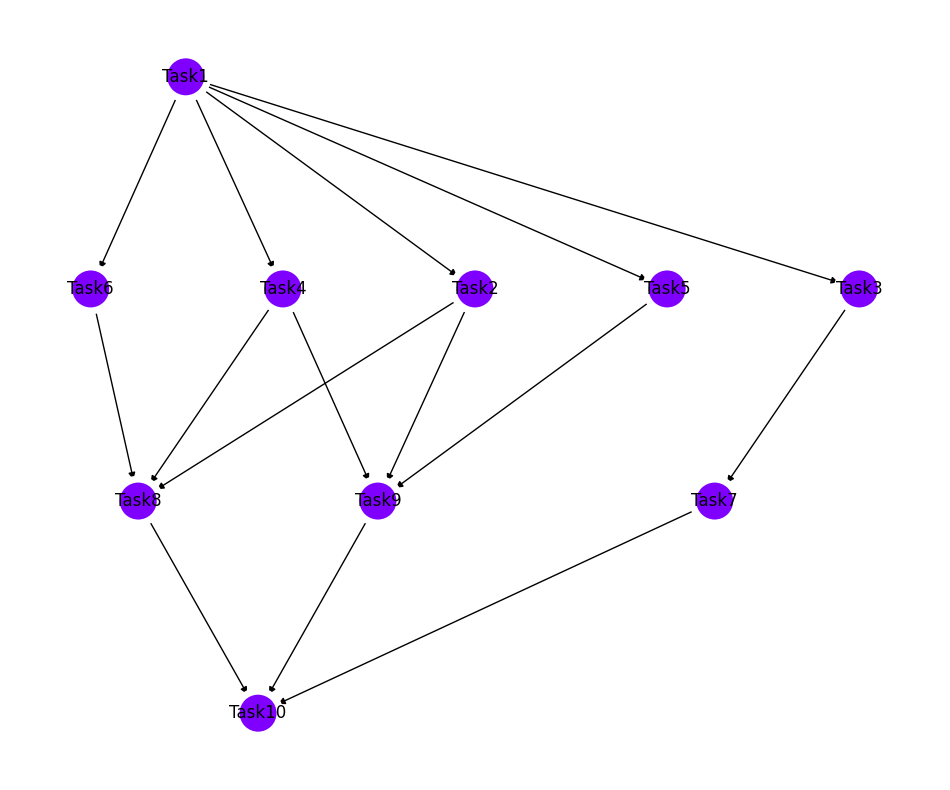

In [6]:
utils.draw(workflow.wf_instance.workflow, with_labels=True)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

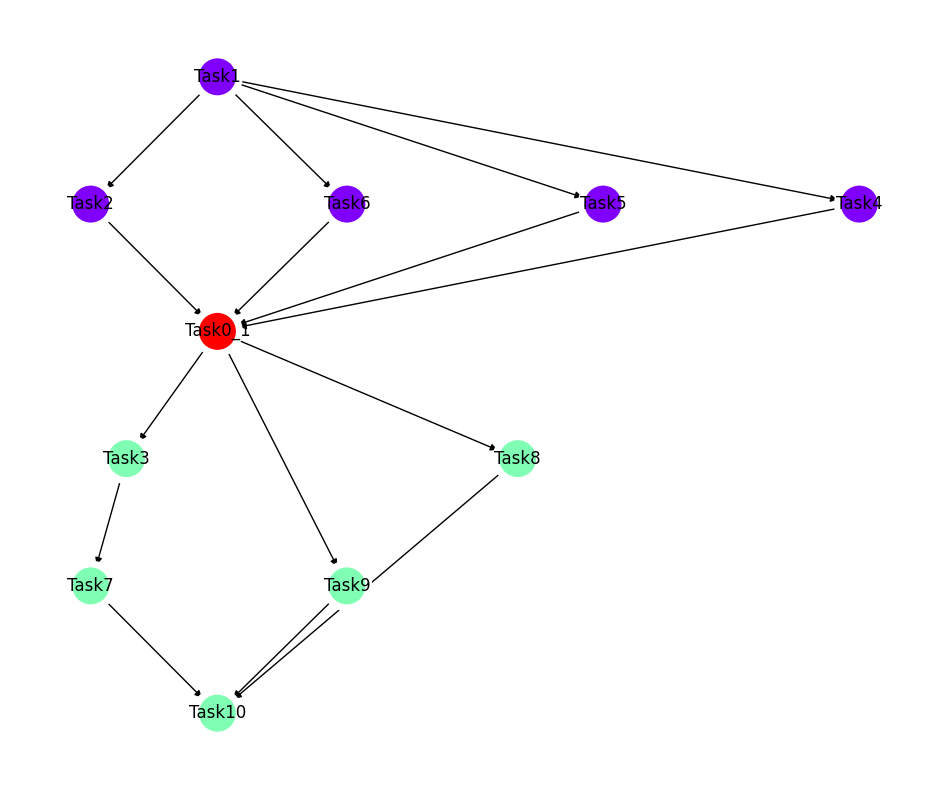

In [7]:
workflow1, workflow2 = HeftBasedAlgorithm().decompose(workflow, 2)
merged = merge_subworkflows([workflow1, workflow2])
utils.draw(merged, with_labels=True)

## Simple Method

In [3]:
tasks_file =  "workflows_data/workflows/complex_workflow.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50
workflow = Workflow(tasks_file, machines_file, deadline)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

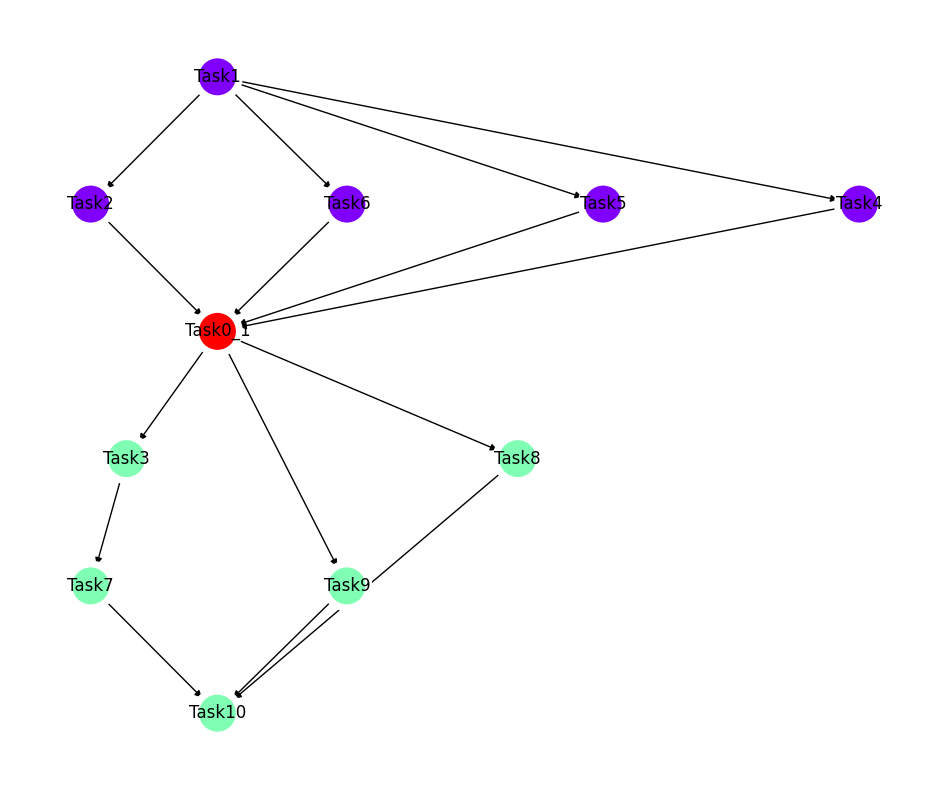

In [9]:
workflow1, workflow2 = SimpleSplit().decompose(workflow, 2)
merged = merge_subworkflows([workflow1, workflow2])
utils.draw(merged, with_labels=True)

## Test preprocessing

In [2]:
tasks_file =  "workflows_data/workflows/complex_workflow_no_entry_and_exit.json"
machines_file = "workflows_data/machines/machines_for_3_tasks_3_machines_1_path.json"
deadline = 50
workflow = Workflow(tasks_file, machines_file, deadline)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

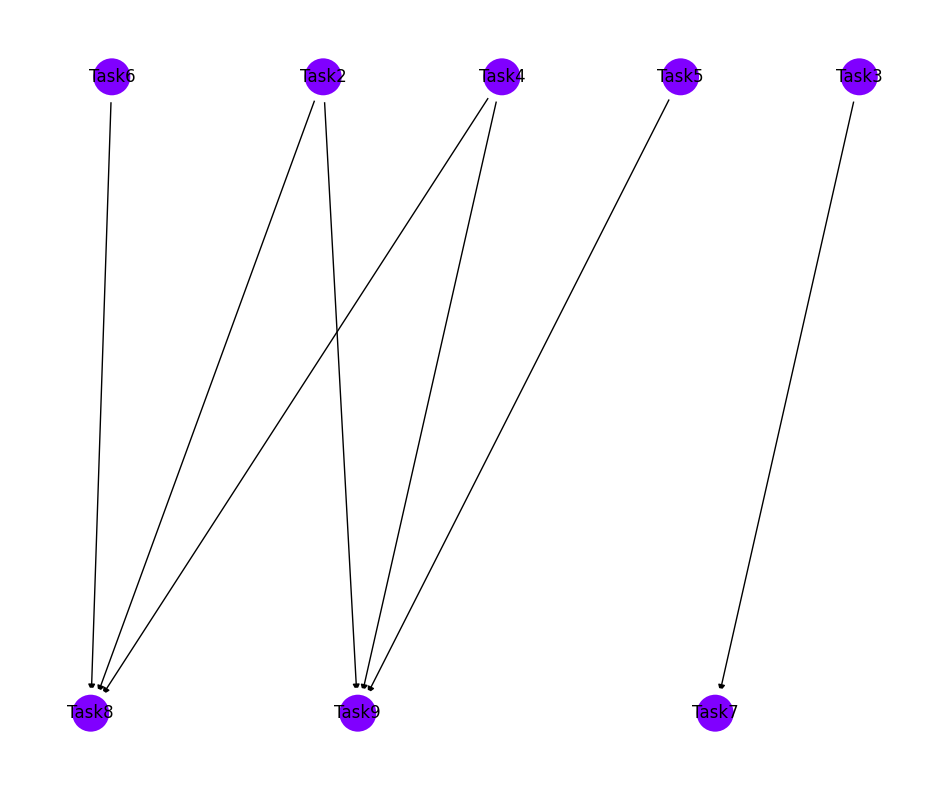

In [3]:
draw(workflow.wf_instance.workflow, with_labels=True)

In [4]:
new_workflow = preprocess_workflow(workflow)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

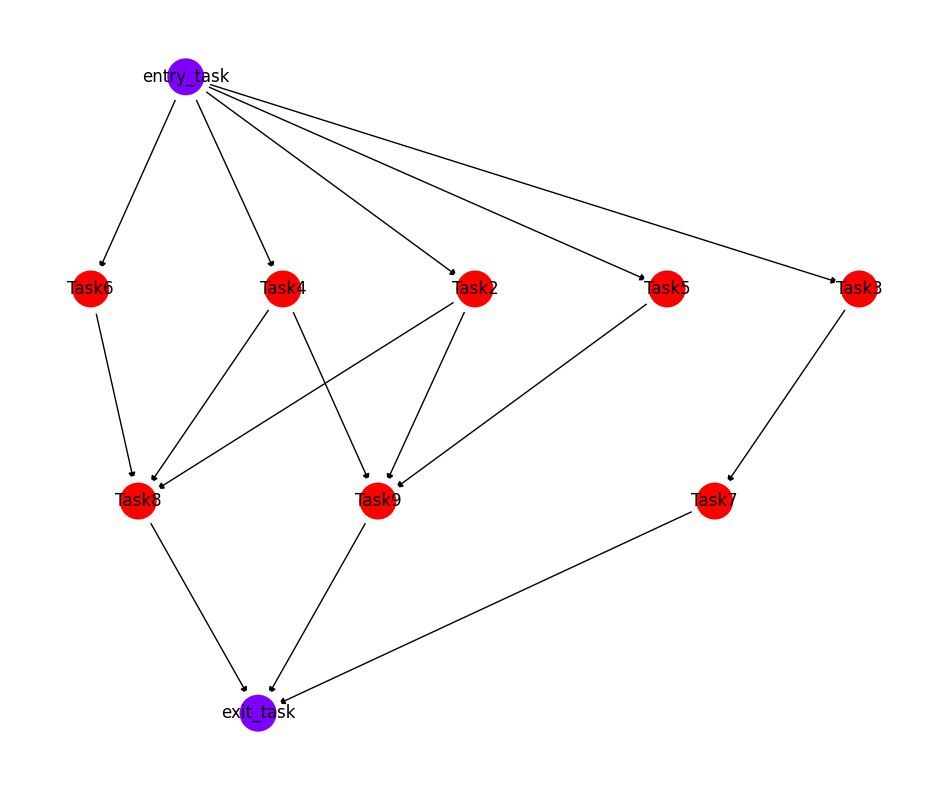

In [5]:
draw(new_workflow, with_labels=True)

## Divide real workflow

In [3]:
tasks_file = "workflows_data/workflows/1000genome_22_tasks.json"

workflow_genome = Workflow(tasks_file, machines_file, deadline)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

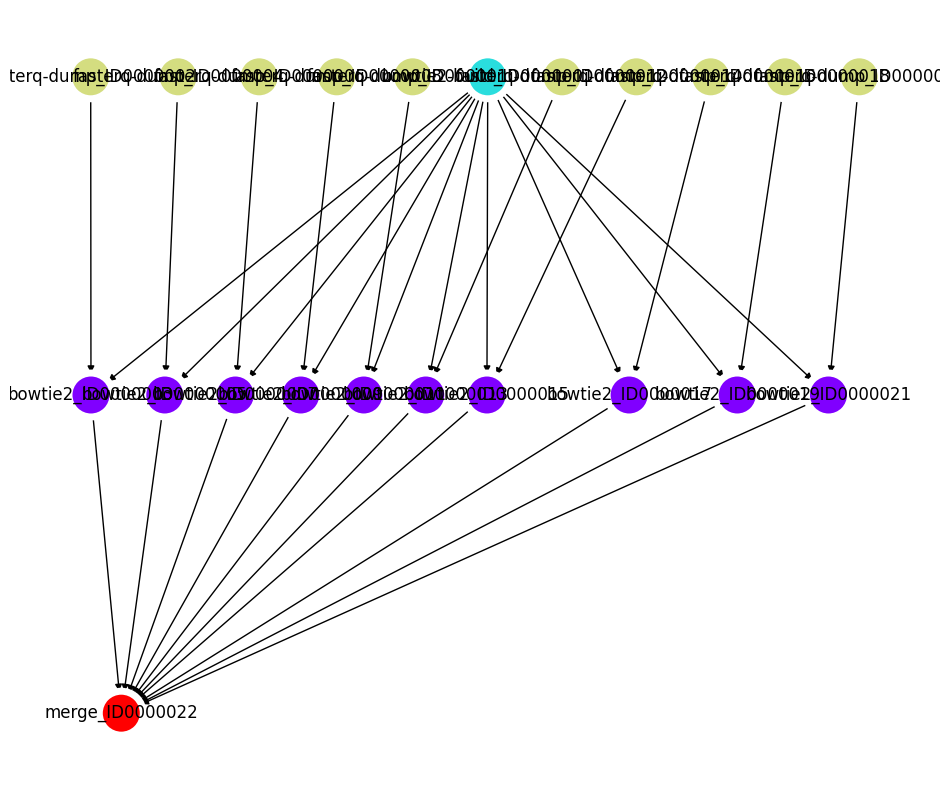

In [4]:
utils.draw(workflow_genome.wf_instance.workflow, with_labels=True)

In [5]:
new_workflow = preprocess_workflow(workflow_genome)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

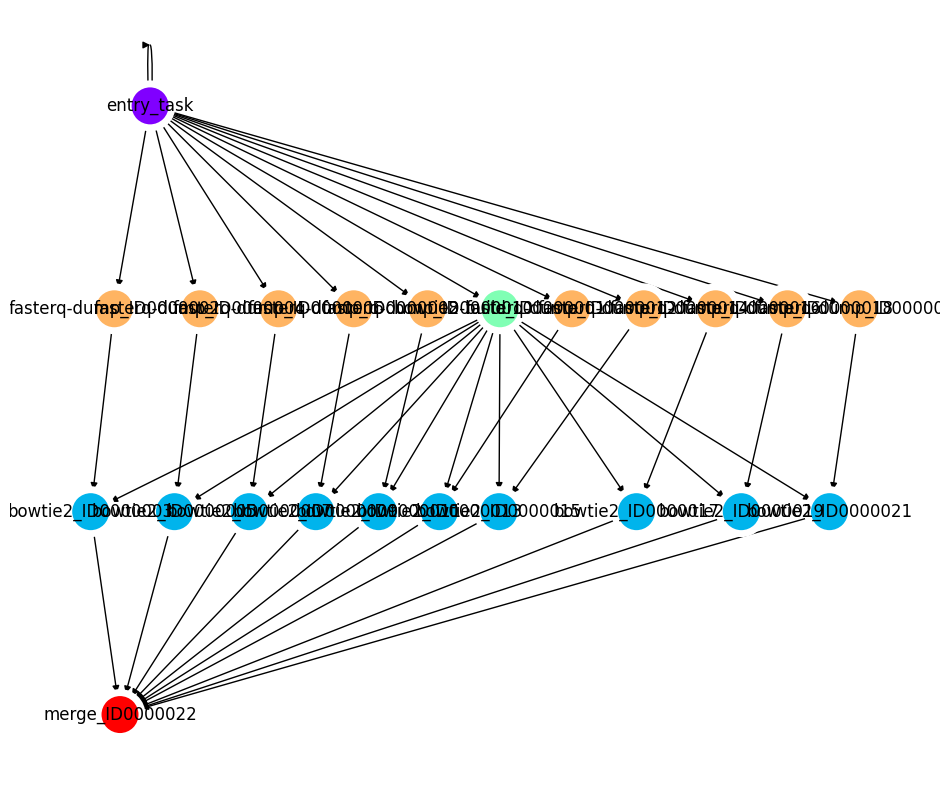

In [6]:
utils.draw(new_workflow, with_labels=True)